In [1]:
hidden1_size = 64
output_size = 4
n_epochs = 200  # suggest training between 20-50 epochs
batch_size_test = 5
batch_size_train = 5

In [2]:
import torch
import torchvision
import matplotlib as plt
from pylab import *

In [3]:
from sklearn import svm
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

def shuffle_in_unison(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)


## data use deltas
DATA_PATH = 'pyDatasetTools/data/'
DATA_PATH_ubrain = '/mnt/space/datasets/radar8ghz/processed_ubrain/'

dimx = 16      # we need to trash one chirp as we do diff!
dimy = 16  
channels = 2
validation_split = 0.8
freq_input = 155

data_x = pd.read_csv(DATA_PATH_ubrain + "all_data_radar_1.0_28x28.txt")
data_y = pd.read_csv(DATA_PATH_ubrain + "all_label_radar_1.0_28x28.txt")

data_x_ = []
data_y_ = []
for i in range(len(data_x.values)):
    this_x = (((np.reshape(data_x.values[i],[-1,28 ,28])/1)-0.5)*2.0).astype('float32') ## OR 255!
    this_x = np.resize(this_x, [1, 16,16])
    this_x = this_x + 1
    idx_freq = np.where(this_x == 2)
    this_x[idx_freq] = 2
    this_y = np.squeeze( np.reshape(data_y.values[i], [-1]) ) 
    data_x_.append( this_x ) 
    data_y_.append( this_y )

In [4]:
## data use microdoppler
DATA_PATH_ubrain = '/mnt/space/datasets/radar8ghz/processed/'

dimx = 16      # we need to trash one chirp as we do diff!
dimy = 16  
channels = 2
validation_split = 0.8

data_x = np.load(DATA_PATH_ubrain+"udoppler_spikes_small.npy")
data_y = np.load(DATA_PATH_ubrain+"labeldata.npy")

from skimage.transform import resize
data_x_ = []
data_y_ = []
for i in range(len(data_x)):
    this_x = (((np.reshape(data_x[i],[28,28])))).astype('float32')
    this_x = resize(this_x, [16,16])
    mean_  = np.mean(this_x)
    std_ = np.std(this_x)
    thr_ = mean_ + 0.15*std_
    thr_m = mean_ - 0.15*std_
    idx_freq = np.where(this_x >=  thr_)
    idx_freq_n = np.where(this_x <  thr_m)
    this_x[:] = 0
    this_x[idx_freq] = 2
    #this_x[idx_freq_n] = 1
    this_y = np.squeeze( np.reshape(data_y[i], [-1]) ) 
    data_x_.append( this_x ) 
    data_y_.append( this_y )

In [5]:
shuffle_in_unison(data_x_, data_y_)

#use 80 % train and 20% test    
n_train = round(len(data_x)*validation_split)
n_test = len(data_x)-n_train

## combine the tree classes into 1
data_y_ = np.reshape(data_y_,[-1])
print(np.shape(data_x_))
print(n_test)

(1322, 16, 16)
264


In [6]:
#idx_z = data_y_ == 0
#idx_o = data_y_ == 1
#idx_t = data_y_ == 2
#idx_e = data_y_ == 3
#idx_b = data_y_ == 4

#data_y_[idx_z] = 0
#data_y_[idx_o] = 0
#data_y_[idx_t] = 0
#data_y_[idx_e] = 1
#data_y_[idx_b] = 2

# ['Hel', 'Tow', 'Hor', 'Bck', 'Ver']
idx_e = data_y_ == 0
idx_t = data_y_ == 1
idx_h = data_y_ == 2
idx_b = data_y_ == 3
idx_v = data_y_ == 4

data_y_[idx_e] = 0
data_y_[idx_t] = 1
data_y_[idx_h] = 2
data_y_[idx_b] = 3
data_y_[idx_v] = 2

In [7]:
from sklearn.model_selection import train_test_split #liste_mffc
X_train, X_test, y_train, y_test=train_test_split(data_x_,data_y_, test_size=0.25,random_state=31)

from sklearn import svm
clf = svm.SVC()
clf.fit(np.reshape(X_train, [-1,16*16]), y_train)
pred_ = clf.predict(np.reshape(X_test,[-1,16*16]))
correct = np.sum(y_test == pred_)
accuracy_ = float(correct) / len(y_test)
print("Accuracy SVM " +str(accuracy_))
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred_)
print(cm)

Accuracy SVM 0.9818731117824774
[[ 53   0   0   2]
 [  0  71   1   0]
 [  1   2 150   0]
 [  0   0   0  51]]


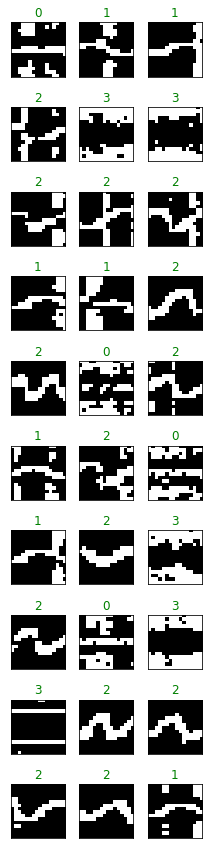

In [8]:
fig = plt.figure(figsize=(3, 12))

for idx in np.arange(30):
    ax = fig.add_subplot(10, 3, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(np.reshape(X_train[idx], [16,16])), cmap='gray')
    ax.set_title("{}".format(str(y_train[idx].item())),color=("green"))
    plt.tight_layout()

In [9]:
import torch
import torchvision
from torch.utils.data import TensorDataset, DataLoader

batch_size_test = 6
batch_size_train = 6

tensor_x = torch.tensor(X_train) # transform to torch tensor
tensor_y = torch.tensor(y_train)
tensor_test_x = torch.tensor(X_test) # transform to torch tensor
tensor_test_y = torch.tensor(y_test)
train_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
test_dataset = TensorDataset(tensor_test_x,tensor_test_y) # create your datset
train_loader = DataLoader(train_dataset,  batch_size=batch_size_train, shuffle=True) 
                               # create your dataloader
test_loader = DataLoader(test_dataset,batch_size=batch_size_test, shuffle=True,) # create your dataloader


In [10]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [11]:
example_data.shape
example_data[1][0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 2., 0., 0.])

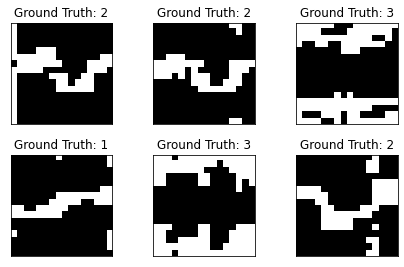

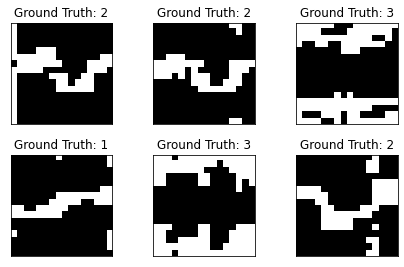

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [13]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()


Using device: cuda



In [14]:
import torch.nn as nn
import torch.nn.functional as F


## Define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
    
        self.fc1 = nn.Linear(example_data.shape[1] * example_data.shape[2], hidden1_size, bias=False)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(hidden1_size, output_size, bias=False)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.1)

        
    def forward(self, x):
        # flatten image input
        x = x.view(-1, example_data.shape[1] * example_data.shape[2])
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        return x

# initialize the NN
#mask = torch.tensor([[1,0,0,1],[1,1,0,0],[1,1,1,0],[0,1,1,1],[0,0,1,1]])
model = Net()

#model = Net()
print(model)

Net(
  (fc1): Linear(in_features=256, out_features=64, bias=False)
  (fc2): Linear(in_features=64, out_features=4, bias=False)
  (dropout): Dropout(p=0.1, inplace=False)
)


In [15]:
## Specify loss and optimization functions

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [16]:
# number of epochs to train the model

model.train() # prep model for training
n_epochs = 50
for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))

Epoch: 1 	Training Loss: 0.342880
Epoch: 2 	Training Loss: 0.122679
Epoch: 3 	Training Loss: 0.074096
Epoch: 4 	Training Loss: 0.031078
Epoch: 5 	Training Loss: 0.017929
Epoch: 6 	Training Loss: 0.007096
Epoch: 7 	Training Loss: 0.012194
Epoch: 8 	Training Loss: 0.005285
Epoch: 9 	Training Loss: 0.003398
Epoch: 10 	Training Loss: 0.005553
Epoch: 11 	Training Loss: 0.002887
Epoch: 12 	Training Loss: 0.001409
Epoch: 13 	Training Loss: 0.001219
Epoch: 14 	Training Loss: 0.001189
Epoch: 15 	Training Loss: 0.001693
Epoch: 16 	Training Loss: 0.000956
Epoch: 17 	Training Loss: 0.000856
Epoch: 18 	Training Loss: 0.000815
Epoch: 19 	Training Loss: 0.000595
Epoch: 20 	Training Loss: 0.001113
Epoch: 21 	Training Loss: 0.001098
Epoch: 22 	Training Loss: 0.000742
Epoch: 23 	Training Loss: 0.000947
Epoch: 24 	Training Loss: 0.000483
Epoch: 25 	Training Loss: 0.001124
Epoch: 26 	Training Loss: 0.000956
Epoch: 27 	Training Loss: 0.000727
Epoch: 28 	Training Loss: 0.000583
Epoch: 29 	Training Loss: 0.0

In [17]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
batch_size = 100
import numpy as np

model.eval() # prep model for *evaluation*

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(target.size()[0]):
        if(target.size()[0] > 1):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
        else:
            label = target.data[i]
            class_correct[label] += correct.item()
            class_total[label] += 1
            
# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(np.unique(y_train))):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.161698

Test Accuracy of     0: 96% (53/55)
Test Accuracy of     1: 97% (70/72)
Test Accuracy of     2: 94% (145/153)
Test Accuracy of     3: 100% (51/51)

Test Accuracy (Overall): 96% (319/331)


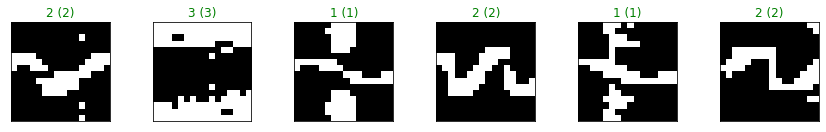

In [18]:
# obtain one batch of test images
for data, target in test_loader:
    images= data
    labels = target
    break

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(6):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

In [19]:
ws0 = model.fc1.weight.detach().cpu().numpy()
ws1 = model.fc2.weight.detach().cpu().numpy()
ws1_f = np.zeros([16,64])
ws1_f[0:4,:] = ws1

In [20]:
#ws1[0,:] = 0
#model.fc2.weights = ws1
#model.to(device)
print(ws1_f[:,0])
ws1 = ws1_f

[-0.08406551 -0.13043371  0.13813655  0.05517982  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.        ]


In [21]:
## rounding weights
def keep_in_bound(w0_round, max_=8, min_=-7):
  to_max = np.where(w0_round>max_)[0]
  to_min = np.where(w0_round<min_)[0]
  w0_round[to_min] = min_
  w0_round[to_max] = max_
  return w0_round

def select_factor(w, max_=8, min_=-7):
    found = False
    w_term = 1
    while found == False:
        w1_round = np.around(w*w_term)
        max_f = np.max(w1_round)
        min_f = np.min(w1_round)
        if(max_f>=max_ or min_f<=min_):
            found=True
            print("max {}".format(max_f))
            print("min {}".format(min_f))  
            print("scale term {}",format(w_term))
        else:
            w_term+=1
    w1_round = np.around(w*w_term)
    return w_term, w1_round

max 7.0
min -6.0
scale term {} 21


(array([2.000e+00, 2.000e+01, 0.000e+00, 6.900e+01, 1.970e+02, 0.000e+00,
        1.038e+03, 4.304e+03, 0.000e+00, 5.375e+03, 3.935e+03, 0.000e+00,
        1.028e+03, 2.960e+02, 0.000e+00, 9.100e+01, 1.900e+01, 0.000e+00,
        9.000e+00, 1.000e+00]),
 array([-6.  , -5.35, -4.7 , -4.05, -3.4 , -2.75, -2.1 , -1.45, -0.8 ,
        -0.15,  0.5 ,  1.15,  1.8 ,  2.45,  3.1 ,  3.75,  4.4 ,  5.05,
         5.7 ,  6.35,  7.  ], dtype=float32),
 <a list of 20 Patch objects>)

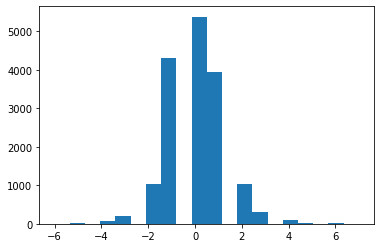

In [22]:
scaling, w0_round = select_factor(ws0, max_=7, min_=-7)
w0_round = keep_in_bound(w0_round, max_=7, min_=-7)
plt.hist(w0_round.reshape([-1]), 20)

max 7.0
min -5.0
scale term {} 10


(array([  2.,   4.,   0.,  12.,   0.,  35.,  52.,   0., 825.,   0.,  25.,
         20.,   0.,  12.,   0.,  16.,  11.,   0.,   8.,   2.]),
 array([-5. , -4.4, -3.8, -3.2, -2.6, -2. , -1.4, -0.8, -0.2,  0.4,  1. ,
         1.6,  2.2,  2.8,  3.4,  4. ,  4.6,  5.2,  5.8,  6.4,  7. ]),
 <a list of 20 Patch objects>)

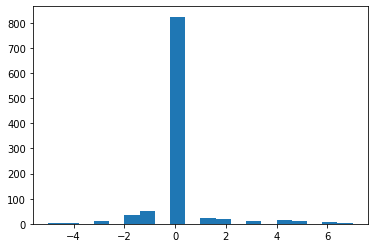

In [23]:
scaling, w1_round = select_factor(ws1, max_=7, min_=-7)
w1_round = keep_in_bound(w1_round, max_=7, min_=-7)
plt.hist(w1_round.reshape([-1]), 20)

In [24]:
import os
from datetime import date
today = date.today()
folder = './networks/radar_256x'+ str((hidden1_size)) +'x' +str(output_size)
try:
    os.stat(folder)
except:
    os.mkdir(folder)

In [25]:
np.savetxt(folder+'/WS0',w0_round.T, fmt="%d")
np.savetxt(folder+'/WS1',w1_round.T, fmt="%d")

In [26]:
w0_round.T.shape

(256, 64)

In [27]:
w1_round.T.shape

(64, 16)

In [28]:
model.eval() # prep model for *evaluation*


data=data.detach().cpu().numpy()
target=target.detach().cpu().numpy()

In [29]:
directory_ = folder

f_x=open(directory_+'/X.txt','ab')
f_y=open(directory_+'/Y.txt','ab')

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    print(data.shape)
    # Append 'hello' at the end of file
    for this_test in range(data.shape[0]):
        input_mean_rate = np.array(np.round((data[this_test,:,:].reshape([-1]))))
        idx_freq = np.where(input_mean_rate == 2)
        input_mean_rate[idx_freq] = 150
        label = target[this_test]
        #print(label)
        np.savetxt(f_x,[input_mean_rate], delimiter='\t', fmt="%d")
        np.savetxt(f_y,[label], delimiter='\n', fmt="%d")
f_x.close()
f_y.close()

torch.Size([6, 16, 16])
torch.Size([6, 16, 16])
torch.Size([6, 16, 16])
torch.Size([6, 16, 16])
torch.Size([6, 16, 16])
torch.Size([6, 16, 16])
torch.Size([6, 16, 16])
torch.Size([6, 16, 16])
torch.Size([6, 16, 16])
torch.Size([6, 16, 16])
torch.Size([6, 16, 16])
torch.Size([6, 16, 16])
torch.Size([6, 16, 16])
torch.Size([6, 16, 16])
torch.Size([6, 16, 16])
torch.Size([6, 16, 16])
torch.Size([6, 16, 16])
torch.Size([6, 16, 16])
torch.Size([6, 16, 16])
torch.Size([6, 16, 16])
torch.Size([6, 16, 16])
torch.Size([6, 16, 16])
torch.Size([6, 16, 16])
torch.Size([6, 16, 16])
torch.Size([6, 16, 16])
torch.Size([6, 16, 16])
torch.Size([6, 16, 16])
torch.Size([6, 16, 16])
torch.Size([6, 16, 16])
torch.Size([6, 16, 16])
torch.Size([6, 16, 16])
torch.Size([6, 16, 16])
torch.Size([6, 16, 16])
torch.Size([6, 16, 16])
torch.Size([6, 16, 16])
torch.Size([6, 16, 16])
torch.Size([6, 16, 16])
torch.Size([6, 16, 16])
torch.Size([6, 16, 16])
torch.Size([6, 16, 16])
torch.Size([6, 16, 16])
torch.Size([6, 1

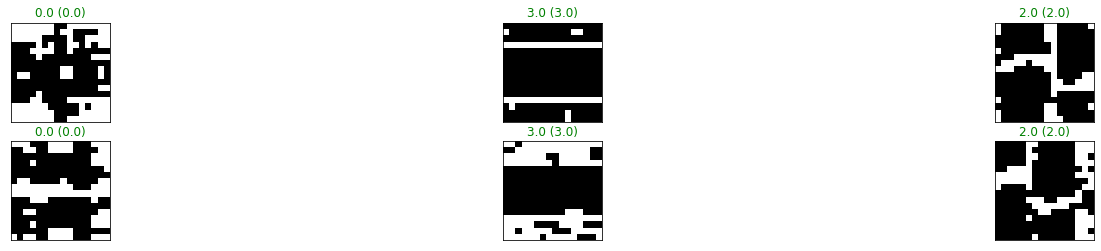

In [30]:
x_ = np.loadtxt(directory_+'/X.txt',dtype='float',delimiter="\t")
y_ = np.loadtxt(directory_+'/Y.txt',dtype='float',delimiter="\t")
#plt.imshow(np.reshape(x_[2],[16,16]))
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(6):
    ax = fig.add_subplot(2, 6/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(np.reshape(x_[idx], [16,16])), cmap='gray')
    ax.set_title("{} ({})".format(str(y_[idx].item()), str(y_[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

In [31]:
np.savetxt(directory_+'/WS0',w0_round.T, fmt="%d")
np.savetxt(directory_+'/WS1',w1_round.T, fmt="%d")

In [32]:
w0_round.T.shape

(256, 64)

In [33]:
w1_round.T.shape

(64, 16)

In [34]:
np.savetxt(directory_+'/WS0_T',w0_round, fmt="%d")
np.savetxt(directory_+'/WS1_T',w1_round, fmt="%d")